## DNA Sequencing With Machine Learning

### What is DNA Sequencing?
DNA sequencing is a laboratory technique used to determine the exact sequence of bases (A, C, G, and T) in a DNA molecule.DNA sequence information is important to scientists investigating the functions of genes. The technology of DNA sequencing was made faster and less expensive as a part of the Human Genome Project.

### What is Gene?
Genes are a set of instructions that determine what the organism is like, its appearance, how it survives, and how it behaves in its environment.
A gene consists of a long combination of four different nucleotide bases, or chemicals. There are many possible combinations.

### The four nucleotides are:

A (adenine) C (cytosine) G (guanine) T (thymine) Different combinations of the letters ACGT give people different characteristics. For example, a person with the combination ATCGTT may have blue eyes, while somebody with the combination ATCGCT may have brown eyes.

### Project introduction?
In biological computing, working with DNA sequence data is common place. Becomming familiar with the Python package Biopython will really help you when dealing with biological sequence data in Python. DNA sequence data frequently are contained in a file format called "fasta" format.

### What is FASTA formate?
In bioinformatics, FASTA format is a text-based format for representing nucleotide sequences or amino acid (protein) sequences, in which nucleotides or amino acids are represented using single-letter codes [A,C,G,T,N] where A=Adenosine, C=Cytosine, G=Guanine, T=Thymidine and N= any of A,C,G,T. The format also allows for sequence names and comments to precede the sequences.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
human_data = pd.read_table('human_data.txt')
chimp_data = pd.read_table('chimp_data.txt')
dog_data = pd.read_table('dog_data.txt')
print("human_data:" , human_data.head())
print("Chimp_data:" , chimp_data.head())
print("dog_data:" , dog_data.head())

human_data:                                             sequence  class
0  ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...      4
2  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
3  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
4  ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...      3
Chimp_data:                                             sequence  class
0  ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...      4
2  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
3  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
4  ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...      6
dog_data:                                             sequence  class
0  ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...      4
1  ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...      4
2  ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...      6
3  ATG

### Treating DNA sequence as a "language", otherwise known as  k-mer counting

A challenge that remains is that none of these above methods results in vectors of uniform length, and that is a requirement for feeding data to a classification or regression algorithm. So with the above methods you have to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

DNA and protein sequences can be viewed metaphorically as the language of life. The language encodes instructions as well as function for the molecules that are found in all life forms. The sequence language analogy continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides (motifs) are words, and nucleotide bases and amino acids are the alphabet. Since the analogy seems so apt, it stands to reason that the amazing work done in the natural language processing field should also apply to the natural language of DNA and protein sequences.

The method I use here is simple and easy. I first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

Here I am using hexamer “words” but that is arbitrary and word length can be tuned to suit the particular situation. The word length and amount of overlap need to be determined empirically for any given application.

In genomics, we refer to these types of manipulations as "k-mer counting", or counting the occurances of each possible k-mer sequence. There are specialized tools for this, but the Python natural language processing tools make it supe easy.

Here is a function that can be used to convert any sequence (string) to overlapping k-mer words:

### Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [3]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

## Now we can convert our training data sequences into short overlapping  k-mers of legth 6.  Lets do that for each species of data we have using our getKmers function.

In [4]:
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)
chimp_data['words'] = chimp_data.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp_data = chimp_data.drop('sequence', axis=1)
dog_data['words'] = dog_data.apply(lambda x: getKmers(x['sequence']), axis=1)
dog_data = dog_data.drop('sequence', axis=1)

### Now, our coding sequence data is changed to lowercase, split up into all possible k-mer words of length 6 and ready for the next step.  Let's take a look.

In [5]:
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


### Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use.  We can also make a y variable to hold the class labels.  Let's do that now.

In [6]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values                         

In [7]:
print(human_texts[2])

atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt

In [8]:
y_data

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

## We will perform the same steps for chimpanzee and dog

In [9]:
chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_chimp = chimp_data.iloc[:, 0].values                       # y_c for chimp

dog_texts = list(dog_data['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_dog = dog_data.iloc[:, 0].values   

## Now we will apply the BAG of WORDS using CountVectorizer using NLP

In [10]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [11]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


### If we have a look at class balance we can see we have relatively balanced dataset.

<AxesSubplot:>

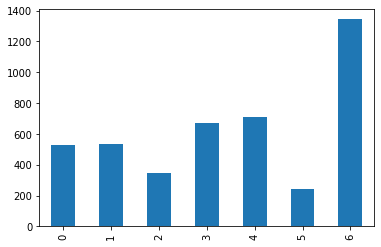

In [12]:
human_data['class'].value_counts().sort_index().plot.bar()

In [13]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [14]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


### A multinomial naive Bayes classifier will be created.  I previously did some parameter tuning and found the ngram size of 4 (reflected in the Countvectorizer() instance) and a model alpha of 0.1 did the best.

In [15]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [16]:
y_pred = classifier.predict(X_test)

In [35]:
from sklearn.metrics import classification_report,confusion_matrix

In [39]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[ 99   0   0   0   1   0   2]
 [  0 104   0   0   0   0   2]
 [  0   0  78   0   0   0   0]
 [  0   0   0 124   0   0   1]
 [  1   0   0   0 143   0   5]
 [  0   0   0   0   0  51   0]
 [  1   0   0   1   0   0 263]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       102
           1       1.00      0.98      0.99       106
           2       1.00      1.00      1.00        78
           3       0.99      0.99      0.99       125
           4       0.99      0.96      0.98       149
           5       1.00      1.00      1.00        51
           6       0.96      0.99      0.98       265

    accuracy                           0.98       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.98      0.98      0.98       876

